In [1]:
import pandas as pd
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import TimeDistributed, RepeatVector, MaxPooling1D, Conv1D, Flatten, Input, Reshape, BatchNormalization
from keras.layers.recurrent import LSTM, GRU
from tensorflow.keras.layers.experimental import RandomFourierFeatures
from keras.models import Sequential, Model
from keras import optimizers
from keras import backend as K
import keras

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

K._get_available_gpus()

Num GPUs Available:  1


2021-11-12 08:29:59.686449: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


['/device:GPU:0']

2021-11-12 08:29:59.692454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 08:29:59.692835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 08:29:59.695538: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-12 08:29:59.695926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [2]:
def load_data(dataframe, cols, target_col, win_len, pred_points, test_size, normalise_window):

    data = dataframe.loc[:,cols]
    n = data.shape[0]
    data_train = data.iloc[:int(n*(1-test_size)),:]
    data_test = data.iloc[int(n*(1-test_size)):,:]

    dmax, dmin = 0, 0
    if normalise_window:        
        min_train = data_train.min()
        max_train = data_train.max()
        data_train = (data_train - min_train)/(max_train - min_train)
        data_test = (data_test - min_train)/(max_train - min_train)
        dmax = max_train[target_col]
        dmin = min_train[target_col]

    sc = {
        'min': dmin,
        'max': dmax
    }

    sequence_length = win_len + pred_points

    X_train, y_train = build_windowed_mat(data_train, target_col, win_len, sequence_length)
    X_test, y_test =  build_windowed_mat(data_test, target_col, win_len, sequence_length)    
   
    return X_train, y_train, X_test, y_test, sc

def build_windowed_mat(data, target_col, win_len, sequence_length):

    # X, y = [], []    
    n_feats = data.shape[1]
    n = data.shape[0]    
    # for index in range(n - sequence_length):
    #     X.append(data.iloc[index: index + win_len,:].values.T.ravel().tolist())
    #     y.append(data[target_col].iloc[index + win_len:index + sequence_length].values.T.ravel().tolist())

    X = [data.iloc[index: index + win_len,:].values.T.ravel().tolist() for index in range(n - sequence_length)]
    y = [data[target_col].iloc[index + win_len:index + sequence_length].values.T.ravel().tolist() for index in range(n - sequence_length)]

    X = np.array(X)    
    X = np.reshape(X, (X.shape[0], win_len, n_feats), order='F')
    y = np.array(y)
    y = np.reshape(y, (y.shape[0], sequence_length - win_len, len(target_col)), order='F')
   
    return X,y

def predict_sequence_full_univar(model, curr_frame, pred_points, future_points):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    if len(curr_frame.shape) == 1:
        curr_frame = curr_frame[np.newaxis,:,np.newaxis]
    elif len(curr_frame.shape) == 2:
        curr_frame = curr_frame[np.newaxis,:,:]

    predicted = []   
    N = int(np.ceil(future_points/pred_points) )
    for i in range(N):        
        # predicted += model.predict(curr_frame)[0,:].tolist()
        predicted += model.predict(curr_frame)[0,:,0].tolist()
        curr_frame = np.array(curr_frame[0,pred_points:,0].tolist() + predicted[-pred_points:])    
        curr_frame = curr_frame[np.newaxis,:,np.newaxis]
        
    return np.array(predicted)
    
def plot_results(predicted_data, true_data, dates, step):
    fig = go.Figure()
    x = np.array(range(0,true_data.size, step), dtype=int)
    dates = np.array(dates)
    fig.add_trace(go.Scatter(y=true_data, mode='lines', name='True Data'))
    fig.add_trace(go.Scatter(y=predicted_data, mode='lines', name='Prediction'))
    fig.update_layout(
        xaxis = dict(
            tickmode = 'array',
            tickvals = x,
            ticktext = dates[x],
            tickangle = 60
        ),
        margin = dict(
            autoexpand=False,
            l=30,
            r=30,
            b=100
        )
    )
    fig.show()


def plot_time_serie(time_serie_train, time_serie_test, x_ticks):
    train_len = len(time_serie_train)
    test_len = len(time_serie_test)
    time = np.arange(0, train_len + test_len, 1)
    plt.figure(facecolor='white', figsize=(25,5)) 
    plt.plot(time[0:train_len],time_serie_train, label='Train Data') 
    plt.plot(time[train_len:],time_serie_test, label='Test data')
    plt.xticks(time[0:time.size:100], x_ticks[0:time.size:100], rotation=90, fontsize=10)
    plt.legend()
    plt.xlim(0,time.size)
    plt.title('Deliveries per hour')
    plt.grid(True)
    plt.show()

In [24]:
tienda = 'Tienda83'
model_df = pd.read_csv('data/model_data_' + tienda + 'last.csv')
model_df.set_index('FechaHora', inplace=True)

(7652, 24, 1) (7652, 1, 1) (829, 24, 1) (829, 1, 1)


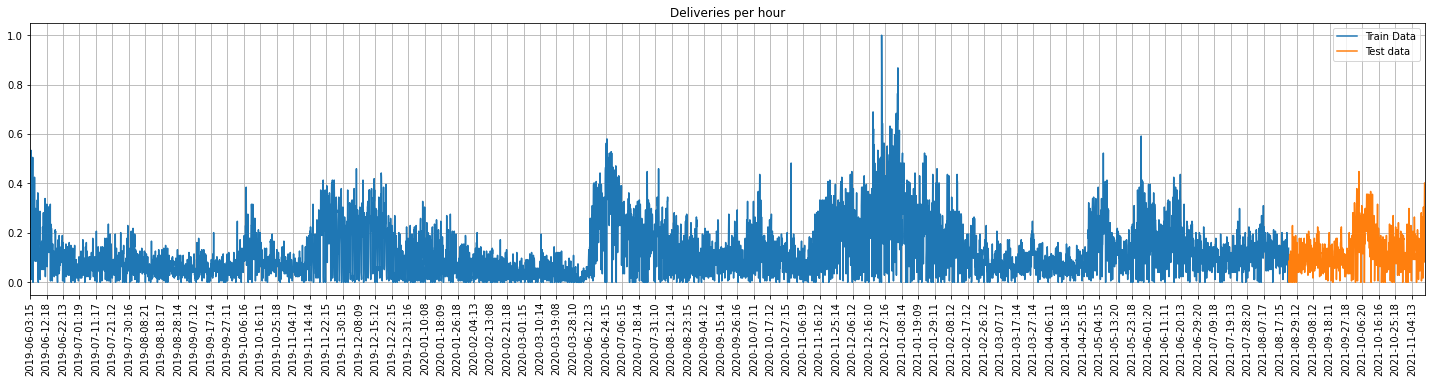

In [5]:
feats = ['No_Clientes']
pred_points = 1
window_len = 24
normalize = True
test_size = .1
X_train, y_train, X_test, y_test, sc = load_data(model_df, feats, ['No_Clientes'], window_len, pred_points, test_size, normalize)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
n = model_df.shape[0]
xtick_labels = model_df.index.tolist()[window_len+pred_points:int(n*(1-test_size))] + model_df.index.tolist()[int(n*(1-test_size))+window_len+pred_points:]
plot_time_serie(y_train[:,0,-1], y_test[:,0,-1], xtick_labels)

In [6]:
model = keras.models.load_model('models/Modelo'+tienda+'Win24ConvEncUVv2')
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 14, 32)            384       
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 4, 64)             22592     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 2, 64)             0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 128)               0         
_________________________________________________________________
repeat_vector_12 (RepeatVect (None, 1, 128)            0         
_________________________________________________________________
gru_12 (GRU)                 (None, 1, 24)             11016     
_________________________________________________________________
dropout_12 (Dropout)         (None, 1, 24)           

In [7]:
# Single point train reconstruction
predictions = model.predict(X_train)
print(predictions.shape)
print(y_train.shape)
if normalize:
    predictions = predictions[:,0,0]*(sc['max']['No_Clientes'] - sc['min']['No_Clientes']) + sc['min']['No_Clientes']
    label_train = y_train[:,0,0]*(sc['max']['No_Clientes'] - sc['min']['No_Clientes']) + sc['min']['No_Clientes']

xtick_labels = model_df.index.tolist()[:int(n*(1-test_size))+window_len+pred_points]
plot_results(predictions[:],label_train[:], xtick_labels, 110)
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print(mean_squared_error(predictions,label_train))
print(mean_absolute_error(predictions,label_train))
print(mean_absolute_percentage_error(predictions,label_train))

2021-11-12 08:31:32.641535: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-12 08:31:33.640273: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


(7652, 1, 1)
(7652, 1, 1)


76.05253179611594
6.677021792295773
0.3335651148556904


In [8]:
# Single point prediction
predictions = model.predict(X_test)
print(predictions.shape)
print(y_test.shape)
if normalize:
    predictions = predictions[:,0,0]*(sc['max']['No_Clientes'] - sc['min']['No_Clientes']) + sc['min']['No_Clientes']
    label_test = y_test[:,0,0]*(sc['max']['No_Clientes'] - sc['min']['No_Clientes']) + sc['min']['No_Clientes']

xtick_labels = model_df.index.tolist()[int(n*(1-test_size))+window_len+pred_points:]
plot_results(predictions[:],label_test[:], xtick_labels, 20)
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print(mean_squared_error(predictions,label_test))
print(mean_absolute_error(predictions,label_test))
print(mean_absolute_percentage_error(predictions,label_test))

(829, 1, 1)
(829, 1, 1)


85.77194263454489
7.043748982133854
0.3336970262429677


In [17]:
# Autoregresive prediction
num = 818
pred_hor = 11
test_sample = X_test[num,:,:]
test_sample = test_sample[np.newaxis,:,:]
predictions = predict_sequence_full_univar(model, test_sample, pred_points, pred_hor) 
print(predictions.shape)
if normalize:
    predictions = predictions*(sc['max']['No_Clientes'] - sc['min']['No_Clientes']) + sc['min']['No_Clientes']
    label_test = y_test[num:num+pred_hor,0,0]*(sc['max']['No_Clientes'] - sc['min']['No_Clientes']) + sc['min']['No_Clientes']

xtick_labels = model_df.index.tolist()[int(n*(1-test_size))+window_len+num:]
plot_results(predictions,label_test, xtick_labels, 1)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print(mean_squared_error(predictions,label_test))
print(mean_absolute_error(predictions,label_test))
print(mean_absolute_percentage_error(predictions,label_test))

(11,)


1195.976875407296
27.84232951158827
2.2659734874200903


In [14]:
num = -1
pred_hor = 14
test_sample = X_test[num,:,:]
test_sample = test_sample[np.newaxis,:,:]
predictions = predict_sequence_full_univar(model, test_sample, pred_points, pred_hor)#[1:] # the first value makes reference to the last value of the lat night
print(predictions.shape)
if normalize:
    predictions = predictions*(sc['max']['No_Clientes'] - sc['min']['No_Clientes']) + sc['min']['No_Clientes']

fig = go.Figure()
fig.add_trace(go.Scatter(y=predictions, mode='lines+markers', name='Future Forecast'))
fig.show()


(14,)


In [11]:
predictions.sum()

398.18060083687305

In [12]:
np.round(predictions)

array([46., 39., 16., 21., 26., 36., 35., 35., 36., 34., 39., 36.])